In [49]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label
from utils import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Loading

In [4]:
# Read in cars and notcars
cars = glob.glob('./classifier_data/vehicles/*/*.png')
notcars = glob.glob('./classifier_data/non-vehicles/*/*.png')

# Check that arrays are not empty
print("Number of cars samples - {} ".format( len(cars)) )
print("Number of non-cars samples - {} ".format( len(notcars)) )

Number of cars samples - 8792 
Number of non-cars samples - 8968 


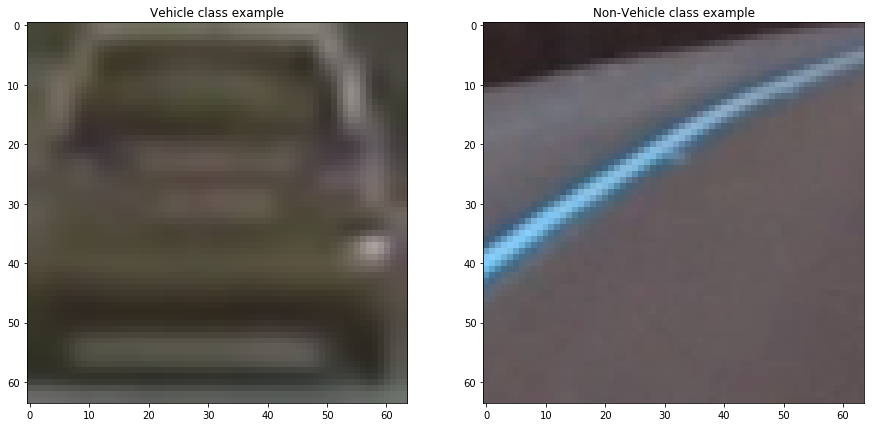

In [214]:
plt.figure(figsize=(15, 25))
plt.subplot(1, 2,1)
plt.imshow(cv2.imread(cars[10]))
plt.title('Vehicle class example')
plt.subplot(1, 2,2)
plt.imshow(cv2.imread(notcars[10]))
plt.title('Non-Vehicle class example')

### Feature visualization

In [217]:
## Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32 # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (40, 40)
xy_overlap_size = (0.75, 0.5)
y_start_stop = [400, 720] # Min and max in y to search in slide_window()



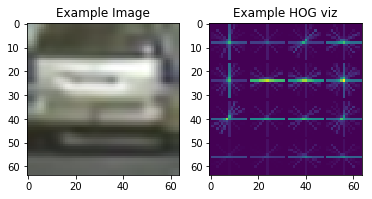

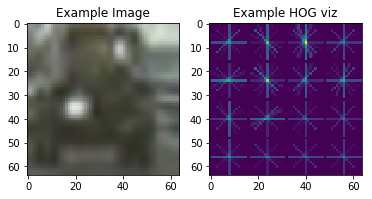

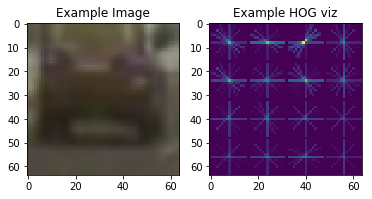

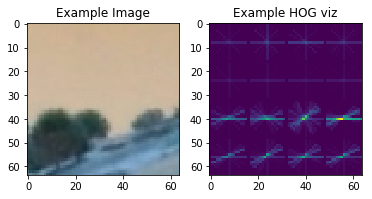

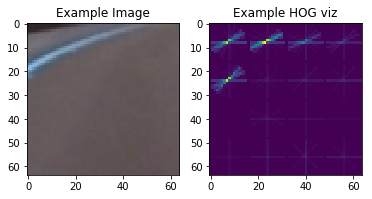

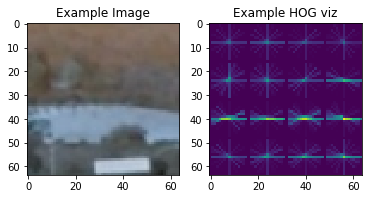

In [218]:

# Parameters below for saving data for future reference
sample = [cars[142],cars[102], cars[15], notcars[112],notcars[100],notcars[200]]


    
test_images = glob.glob("./test_images/test*.jpg")
c = 1


for file in sample: 
    image = cv2.imread(file)
    
    #plt.figure(figsize=(15, 25))
    extract_features([file], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=False )
    #Plot HOG visualisation
    


In [219]:
## Extract features for car
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print ( 'Car samples: {} '.format(len(car_features)))

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print ( 'Not Car samples: {} '.format(len(notcar_features)))
t2 = time.time()
feature_time = round(t2-t, 4)
print( feature_time, " seaconds to extract features for training" )
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X) # Fit a per-column scaler
scaled_X = X_scaler.transform(X) # Apply the scaler to X
# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations', pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Car samples: 8792 
Not Car samples: 8968 
99.1046  seaconds to extract features for training
Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4296


### Train Classifier

In [220]:
# Use a linear SVC 
svc = LinearSVC(loss='hinge')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()


5.9833 Seconds to train SVC...
Test Accuracy of SVC =  0.9944


### Sliding Search


114.28 Seconds to process test images


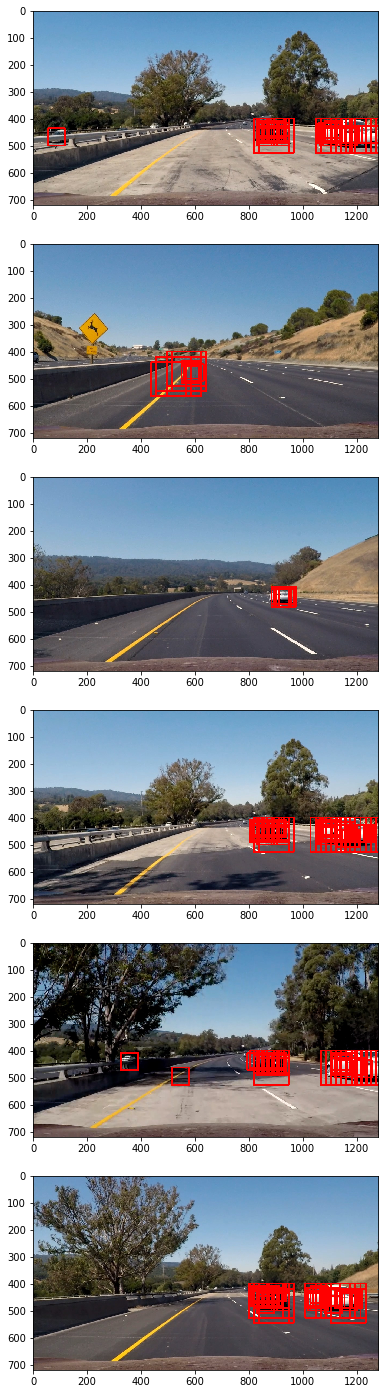

In [271]:
## Run classifier on test images
t=time.time() # Start time
test_images = glob.glob('./test_images/test*.jpg')

plt.figure(figsize=(15, 25))
c = 1

for image_path in test_images:
    image = cv2.imread(image_path)
    draw_image = np.copy(image)
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    windows = []
    windows.extend(windows1)
    windows.extend(windows2)
    
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    plt.subplot(6, 1,c)
    plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
    c+=1
print(round(time.time()-t, 2), 'Seconds to process test images')


#### Hog subsampling window search

In [311]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, 
              hist_bins, bboxes_only=False, draw=False):
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = conv_colorspace(img_tosearch, 'YCrCb')
    global bboxes_list
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            #print ( spatial_features.shape)
            #print (hog_features.shape )
            #print ( hist_features.shape)
            # Scale features and make a prediction
            combined_features = np.hstack((spatial_features, hist_features, hog_features) )
            #print ( combined_features.shape)
            test_features = X_scaler.transform(combined_features)
            test_features = test_features.reshape(1, -1)   
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                left_upper = ( xbox_left, ytop_draw+ystart )
                right_bottom = ( xbox_left+win_draw,ytop_draw+win_draw+ystart )
                w = (left_upper, right_bottom)
                box_list.append( w )
                if draw :
                    cv2.rectangle(draw_img,left_upper,right_bottom,(0,0,255),6) 
    if ( bboxes_only):
        return box_list
    else:
        bboxes_list.append(box_list)
    
    return draw_img
            
    

    
def find_cars_inefficient(image,svc, X_scaler, color_space, spatial_size, 
                          hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat=True,
                         hist_feat=True, hog_feat=True, bboxes_only=False, draw=False ):
    draw_image = np.copy(image)
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    #windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
    #                xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    windows = []
    windows.extend(windows1)
    #windows.extend(windows2)
    global bboxes_list
    hot_windows = []
    hot_windows += (search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
    if draw:
        draw_image = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6) 
        
    if bboxes_only:
        return hot_windows
    else:
        bboxes_list.append(hot_windows)
        return draw_image
        

3.49 Seconds to process test images


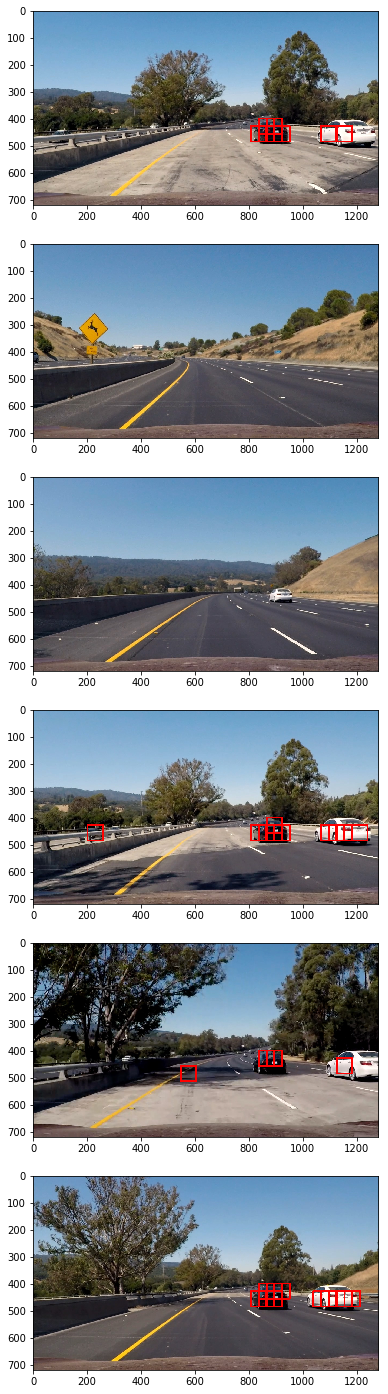

In [325]:
import warnings
warnings.filterwarnings('ignore')

t=time.time() # Start time
test_images = glob.glob('./test_images/test*.jpg')

plt.figure(figsize=(15, 25))

c = 1
ystart = 400
ystop = 656
scale = 1.5

for image_path in test_images:
    image = cv2.imread(image_path)
    #image =  mpimg.imread(image_path)
    out_img = find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins, draw=True)
    #out_img = find_cars_inefficient( image, svc, X_scaler, color_space, spatial_size, 
    #                     hist_bins, orient, pix_per_cell, cell_per_block, 
    #                                hog_channel,draw=True )
    plt.subplot(6, 1,c)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    c+=1
print(round(time.time()-t, 2), 'Seconds to process test images')


In [335]:
### Returns `heatmap` with bounding boxes in `bbox_list` added to it. This function should be applied per frame.
def add_heat(heatmap, box_list):
    # Iterate through list of bboxes
    for box in box_list:
        #print (box)
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap

##    Each element represents a frame. Each element is an array of bboxes found in that frame.
def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    ystart = 400
    ystop = 656
    ## run for multiple size windows
    scale = 1.5
    # Add bounding boxes from this frame
    find_cars(image, ystart, ystop, scale, svc, 
                        X_scaler, orient, pix_per_cell, cell_per_block, 
                        spatial_size, hist_bins, bboxes_only=False, draw=False)
    #find_cars_inefficient( image, svc, X_scaler, color_space, spatial_size, 
    #                      hist_bins, orient, pix_per_cell, cell_per_block, 
    #                      hog_channel,bboxes_only=False, draw=False )
    
    
    # Adjust parameters if needed
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    # Construct heatmap
    for boxlist in all_bboxes[-recent_frames_used:]:
        #print( boxlist )
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    # Visualize the heatmap when displaying    
    #heatmap = np.clip(frame_heatmap, 0, 255)
    
    # Label regions
    labels = label(frame_heatmap)
    
    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #plt.imshow(draw_img)
    return draw_img

##Returns heatmap with false positives removed
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

## Return image with bounding boxes drawn around the labelled regions.
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

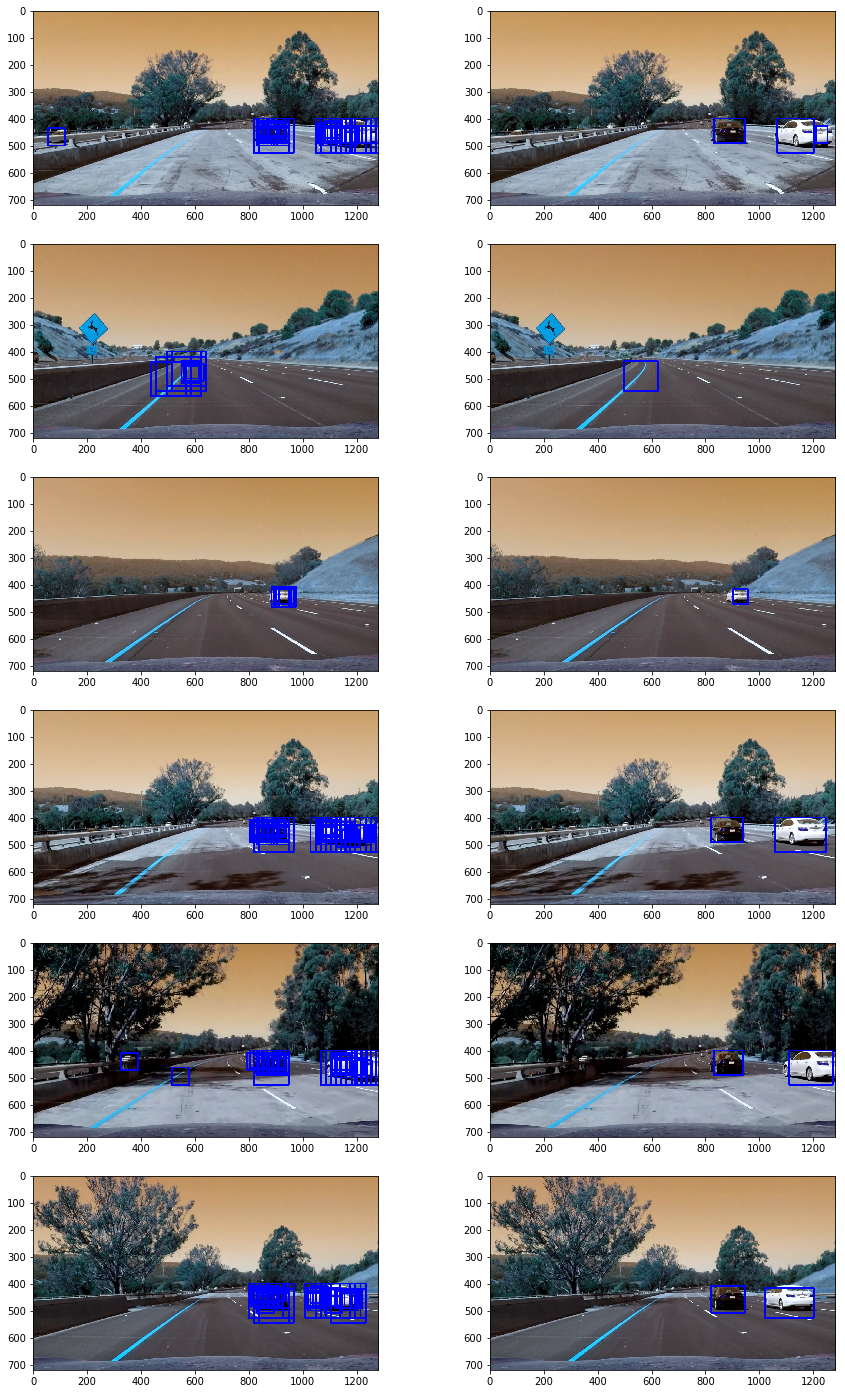

In [305]:
bboxes_list = []
c=1
plt.figure(figsize=(15, 25))
for image_path in test_images:
    image = cv2.imread(image_path)
    out,out2 = process_image(image)
    plt.subplot(6, 2,c)
    plt.imshow(out)
    c+=1
    plt.subplot(6, 2,c)
    plt.imshow(out2)
    c+=1

In [336]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("./project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "project_video_out4.mp4"
%time project_clip.write_videofile(video_output, audio=False)

#print("Bounding boxes: ", bboxes_list)

[MoviePy] >>>> Building video project_video_out4.mp4
[MoviePy] Writing video project_video_out4.mp4


100%|█████████▉| 1260/1261 [03:57<00:00,  5.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out4.mp4 

CPU times: user 3min 48s, sys: 12.3 s, total: 4min
Wall time: 3min 57s
